In [1]:
import os
import os.path as osp
import io
import PIL
from PIL import Image
import lmdb
from tqdm import tqdm
print(PIL.__version__)
print(lmdb.__version__)

7.0.0.post3
0.94


In [2]:
import os
os.chdir("../")
from src.factory.data_factory import DataFactory
from src.factory.config_factory import cfg
from tools.logger import setup_logger
logger = setup_logger("./external/")
cfg.DB.DATA = 'msmt'
cfg.DB.PATH = '/media/allen/mass/DB'
cfg.DB.USE_TRAIN = True
cfg.DB.USE_TEST = True

## Build data

In [4]:
data = DataFactory.produce(cfg)

# Make LMDB

In [12]:
path = '/media/allen/mass/DB/msmt_lmdb'
lmdb_path = osp.join(path, 'lmdb')
train_list = osp.join(path, 'bounding_box_train.txt')
query_list = osp.join(path, 'query.txt')
gallery_list = osp.join(path, 'bounding_box_test.txt')
if not os.path.exists(path):
    os.mkdir(path)
    os.mkdir(lmdb_path)


In [10]:
data.train['indice'][0]

('/media/allen/mass/DB/msmt/bounding_box_train/0368_c7_0000.jpg', 368, 6)

In [11]:
lmdb_env = lmdb.open(path, map_size=int(1e12))
lmdb_txn = lmdb_env.begin(write=True)

for (img_path, _, _) in tqdm(data.train['indice']):
    f_img = open(img_path, 'rb')
    img_str = f_img.read()
    key = img_path.split(cfg.DB.DATA+"/")[-1]
    lmdb_txn.put(key.encode(), img_str)
for (img_path, _, _) in tqdm(data.query['indice']):
    f_img = open(img_path, 'rb')
    img_str = f_img.read()
    key = img_path.split(cfg.DB.DATA+"/")[-1]
    lmdb_txn.put(key.encode(), img_str)
for (img_path, _, _) in tqdm(data.gallery['indice']):
    f_img = open(img_path, 'rb')
    img_str = f_img.read()
    key = img_path.split(cfg.DB.DATA+"/")[-1]
    lmdb_txn.put(key.encode(), img_str)
lmdb_txn.commit()

100%|██████████| 82161/82161 [14:23<00:00, 95.12it/s]


In [13]:
with open(train_list, 'w') as f:
    for (img_path, pid, cid) in tqdm(data.train['indice']):
        key = img_path.split(cfg.DB.DATA+"/")[-1]
        f.write(f"{key},{pid},{cid}\n")
with open(query_list, 'w') as f:
    for (img_path, pid, cid) in tqdm(data.query['indice']):
        key = img_path.split(cfg.DB.DATA+"/")[-1]
        f.write(f"{key},{pid},{cid}\n")
with open(gallery_list, 'w') as f:
    for (img_path, pid, cid) in tqdm(data.gallery['indice']):
        key = img_path.split(cfg.DB.DATA+"/")[-1]
        f.write(f"{key},{pid},{cid}\n")

100%|██████████| 82161/82161 [00:00<00:00, 197253.63it/s]


In [19]:
cfg.DB.DATA

'msmt'

# Test the lmdb data

In [14]:
dataset = []
with open(train_list, 'r') as f:
    for line in f.readlines():
        img_path, pid, cid = line.strip().split(",")
        dataset.append((img_path, pid, cid))

In [16]:
test_lmdb_env = lmdb.open(lmdb_path)
test_lmdb_txn = test_lmdb_env.begin()
raw = test_lmdb_txn.get(dataset[0][0].encode())
img_byte = io.BytesIO(raw)
test_img = Image.open(img_byte)

In [3]:
from src.database.data.cuhk import CUHK01LMDB

In [4]:
data = CUHK01LMDB(path=cfg.DB.PATH, branch='cuhk01_lmdb', use_train=True, use_test=True)

2020-03-31 22:08:12,658 11320 market1501.py INFO: LMDB does not exist, prepare to make one ...
2020-03-31 22:08:12,754 11320 market1501.py INFO: => CUHK01 TRAIN loaded
2020-03-31 22:08:12,755 11320 market1501.py INFO: Dataset statistics:
2020-03-31 22:08:12,756 11320 market1501.py INFO:   ------------------------------
2020-03-31 22:08:12,757 11320 market1501.py INFO:   subset   | # ids | # images
2020-03-31 22:08:12,758 11320 market1501.py INFO:   ------------------------------
2020-03-31 22:08:12,759 11320 market1501.py INFO:   train    |   971 |     3884
2020-03-31 22:08:12,759 11320 market1501.py INFO:   ------------------------------
2020-03-31 22:08:12,761 11320 market1501.py INFO: => CUHK01 VAL loaded
2020-03-31 22:08:12,761 11320 market1501.py INFO: Dataset statistics:
2020-03-31 22:08:12,762 11320 market1501.py INFO:   ------------------------------
2020-03-31 22:08:12,764 11320 market1501.py INFO:   subset   | # ids | # images
2020-03-31 22:08:12,764 11320 market1501.py INFO:

In [8]:
key = data.train['indice'][0][0]
raw = data.train['handle'].get(key.encode())

In [10]:
img_byte = io.BytesIO(raw)
test_img = Image.open(img_byte)

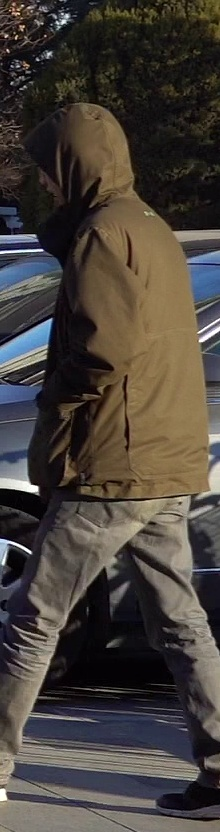

In [11]:
test_img

# Make LMDB for COCO

### making lmdb for train

In [26]:
lmdb_env = lmdb.open(train_lmdb_path, map_size=int(1e12))
lmdb_txn = lmdb_env.begin(write=True)

for (img_path, label) in tqdm(data.train['indice']):
    f_img = open(img_path, 'rb')
    img_str = f_img.read()
    key = img_path.split(cfg.DB.DATA+"/")[-1]
    lmdb_txn.put(key.encode(), img_str)
lmdb_txn.commit()

100%|██████████| 100000/100000 [00:30<00:00, 3254.64it/s]


### making lmdb for val

In [27]:
lmdb_env = lmdb.open(val_lmdb_path, map_size=int(1e12))
lmdb_txn = lmdb_env.begin(write=True)

for (img_path, label) in tqdm(data.val['indice']):
    f_img = open(img_path, 'rb')
    img_str = f_img.read()
    key = img_path.split(cfg.DB.DATA+"/")[-1]
    lmdb_txn.put(key.encode(), img_str)
lmdb_txn.commit()

100%|██████████| 10000/10000 [00:42<00:00, 232.69it/s]


In [34]:
test_lmdb_env = lmdb.open(val_lmdb_path)
test_lmdb_txn = test_lmdb_env.begin()

for (img_path, label) in tqdm(data.val['indice']):
    f_img = open(img_path, 'rb')
    img_str = f_img.read()
    key = img_path.split(cfg.DB.DATA+"/")[-1]
    raw = test_lmdb_txn.get(key.encode())
    img_byte = io.BytesIO(raw)
    test_img = Image.open(img_byte)
    break

  0%|          | 0/10000 [00:00<?, ?it/s]


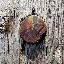

In [35]:
test_img

In [12]:
class A():
    p = 5
    def __init__(self):
        self.j = 1

class B(A):
    p = 6
    def __init__(self):
        super(B, self).__init__()
        print(self.p)

In [16]:
from src.database.data_format.reid import build_reid_dataset
dataset = build_reid_dataset(data.train)

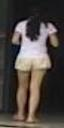

In [22]:
dataset[1000]['inp']